In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from colorama import Fore
from datetime import datetime, date 



from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [2]:
df = pd.read_csv('../../datasets/acea-water-prediction/Aquifer_Petrignano.csv')
df.head()


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
df.describe()

,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
count,4199.000000,5168.000000,5184.000000,4199.000000,4199.000000,5025.000000,4199.000000
mean,1.556633,-26.263723,-25.692926,15.030293,13.739081,-29043.296726,2.372517
std,5.217923,3.319858,3.214165,7.794871,7.701369,4751.864371,0.589088
min,0.000000,-34.470000,-33.710000,-3.700000,-4.200000,-45544.896000,0.000000
25%,0.000000,-28.250000,-27.620000,8.800000,7.700000,-31678.560000,2.100000
50%,0.000000,-25.990000,-25.540000,14.700000,13.500000,-28689.120000,2.400000
75%,0.100000,-23.820000,-23.430000,21.400000,20.000000,-26218.080000,2.700000
max,67.300000,-19.660000,-19.100000,33.000000,31.100000,0.000000,4.100000


<AxesSubplot:>

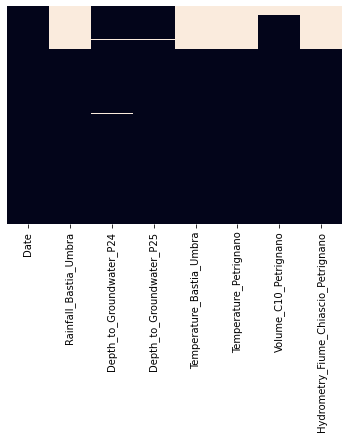

In [4]:
#местонахождение пропусков 
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)


### Предобработка данных 

In [5]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

df.shape

(4199, 8)

In [6]:
df.drop(['Temperature_Petrignano','Depth_to_Groundwater_P24'], axis=1,inplace=True)
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']


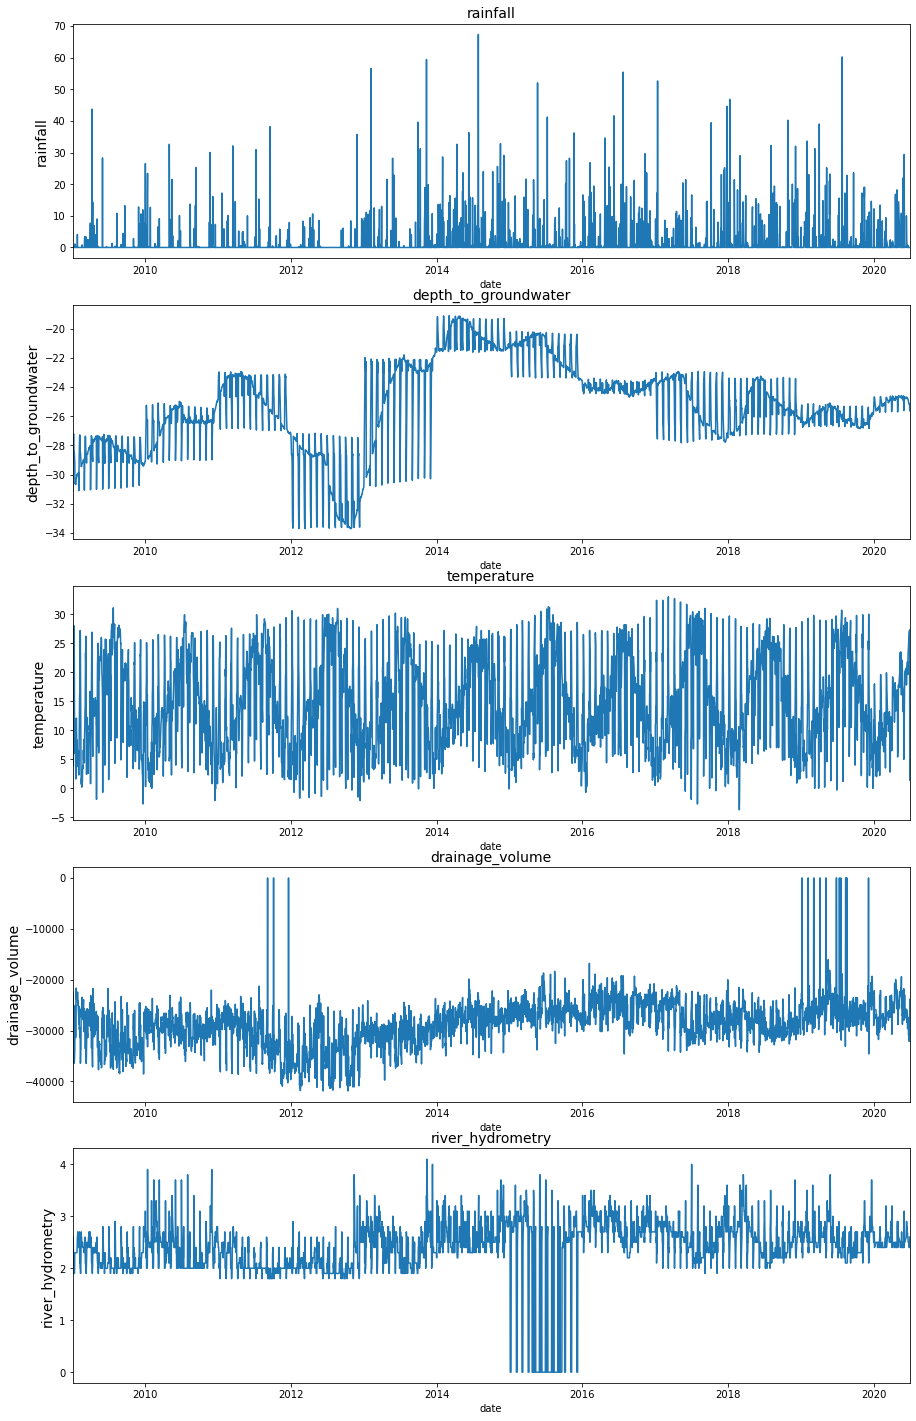

In [7]:
df['date'] = pd.to_datetime(df['date'])


fig, ax = plt.subplots(nrows=5,ncols=1,figsize=(15, 25))

for i, col in enumerate(df.drop('date',axis=1)):
    sns.lineplot(x=df['date'], y=df[col].fillna(method='ffill'), ax=ax[i])
    
    ax[i].set_title(f'{col}',fontsize=14)
    ax[i].set_ylabel(ylabel=col,fontsize=14)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    

#### целевая переменная - depth_to_groundwater

#### по графику видно что в разных интервалах наблюдения имеют разную дисперсию
#### можно выделить несколько групп

In [8]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


dispersion_group
2009-2012    AxesSubplot(0.125,0.2;0.775x0.68)
2012-2014    AxesSubplot(0.125,0.2;0.775x0.68)
2014-2015    AxesSubplot(0.125,0.2;0.775x0.68)
2015-2016    AxesSubplot(0.125,0.2;0.775x0.68)
2016-2017    AxesSubplot(0.125,0.2;0.775x0.68)
2017-2019    AxesSubplot(0.125,0.2;0.775x0.68)
2019-2020    AxesSubplot(0.125,0.2;0.775x0.68)
2020+        AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

<Figure size 2160x720 with 0 Axes>

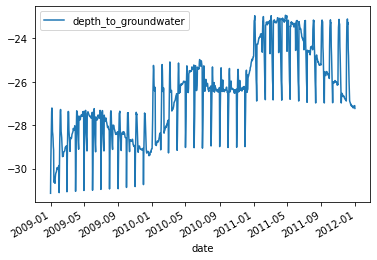

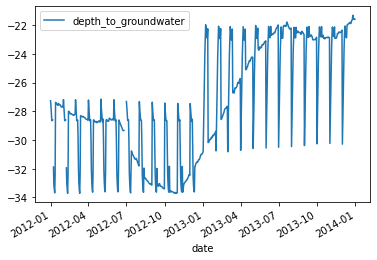

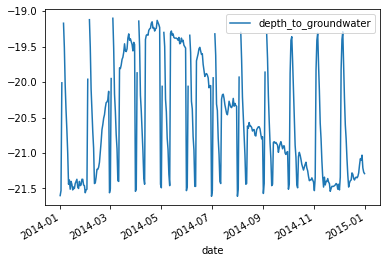

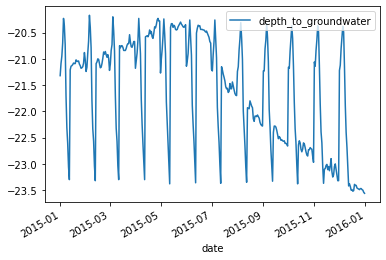

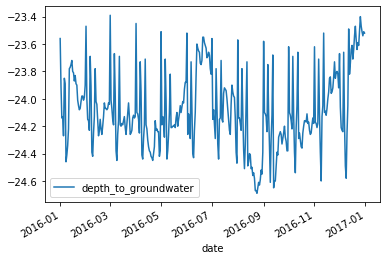

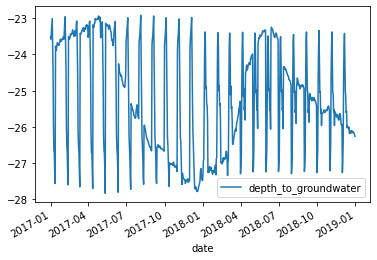

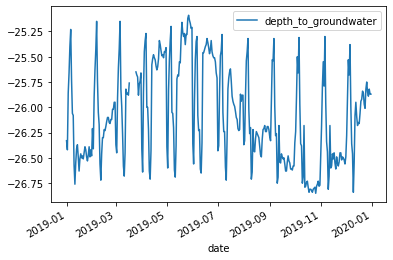

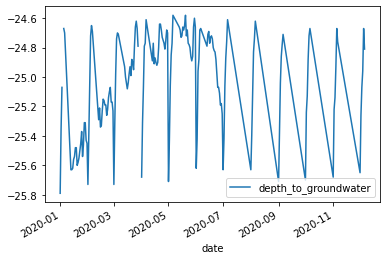

In [9]:

def disp_group(n):
    if n < 2012:
        return '2009-2012'
    elif n < 2014:
        return '2012-2014'
    elif n < 2015:
        return '2014-2015'
    elif n < 2016:
        return '2015-2016'
    elif n < 2017:
        return '2016-2017'
    elif n < 2019:
        return '2017-2019'
    elif n < 2020:
        return '2019-2020'
    else:
        return '2020+'
    
df['dispersion_group'] = df['year'].apply(disp_group)

plt.figure(figsize=(30,10))
df.groupby('dispersion_group')[['date','depth_to_groundwater']].plot(x='date',y='depth_to_groundwater')

In [10]:
#отсортируем данные
df = df.sort_values(by='date',ascending=True)
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,day,month,year,dispersion_group
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,1,1,2009,2009-2012
31,2009-01-02,0.0,-29.74,3.8,-22536.576,2.5,2,1,2009,2009-2012
59,2009-01-03,0.0,-28.91,7.2,-26669.088,2.4,3,1,2009,2009-2012
90,2009-01-04,0.0,-28.03,13.6,-27028.512,2.6,4,1,2009,2009-2012
120,2009-01-05,0.0,-27.39,14.3,-27604.800,2.3,5,1,2009,2009-2012


In [11]:
# интервалы между наблюдениями 
df['delta'] = df['date'] - df['date'].shift(1)


In [16]:
df['delta'].dtype

dtype('<m8[ns]')

#### проверим ряд на стационарность хотя и так видно что дисперсии сильно отличаются 

Критерий Дики-Фуллера :  0.04489977295663725


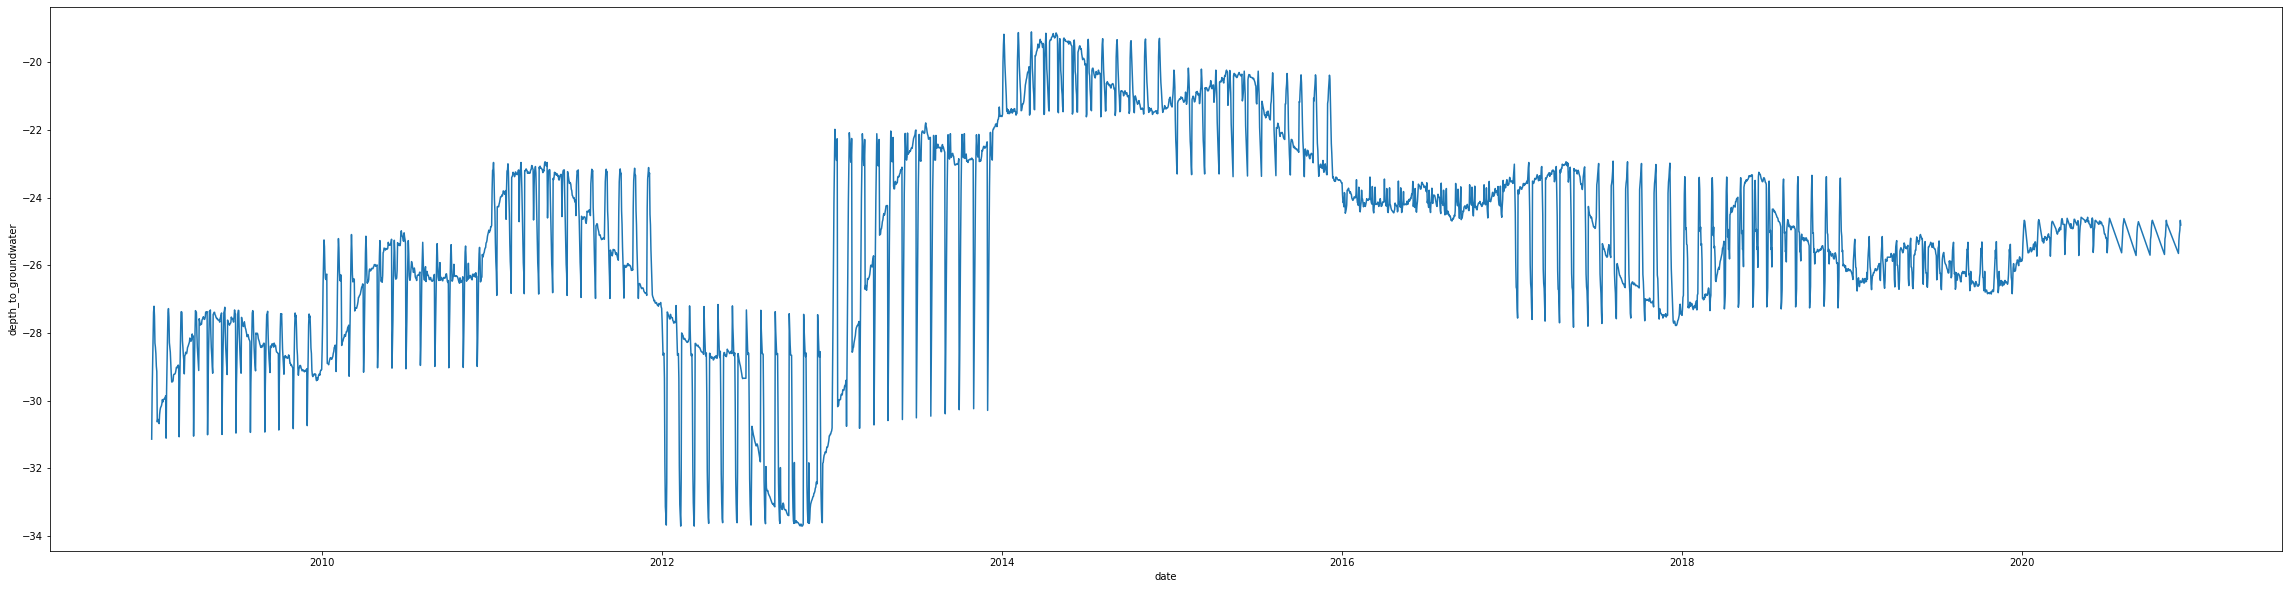

In [52]:
[df[col].fillna(method='ffill',inplace=True) for col in df.columns]

plt.figure(figsize=(40,10))
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'])

print('Критерий Дики-Фуллера : ', sm.tsa.stattools.adfuller(df['depth_to_groundwater'])[1])

#### Попробуем применить Бокс-Кокс преобразование 

Критерий Дики-Фуллера :  0.06567325391185257


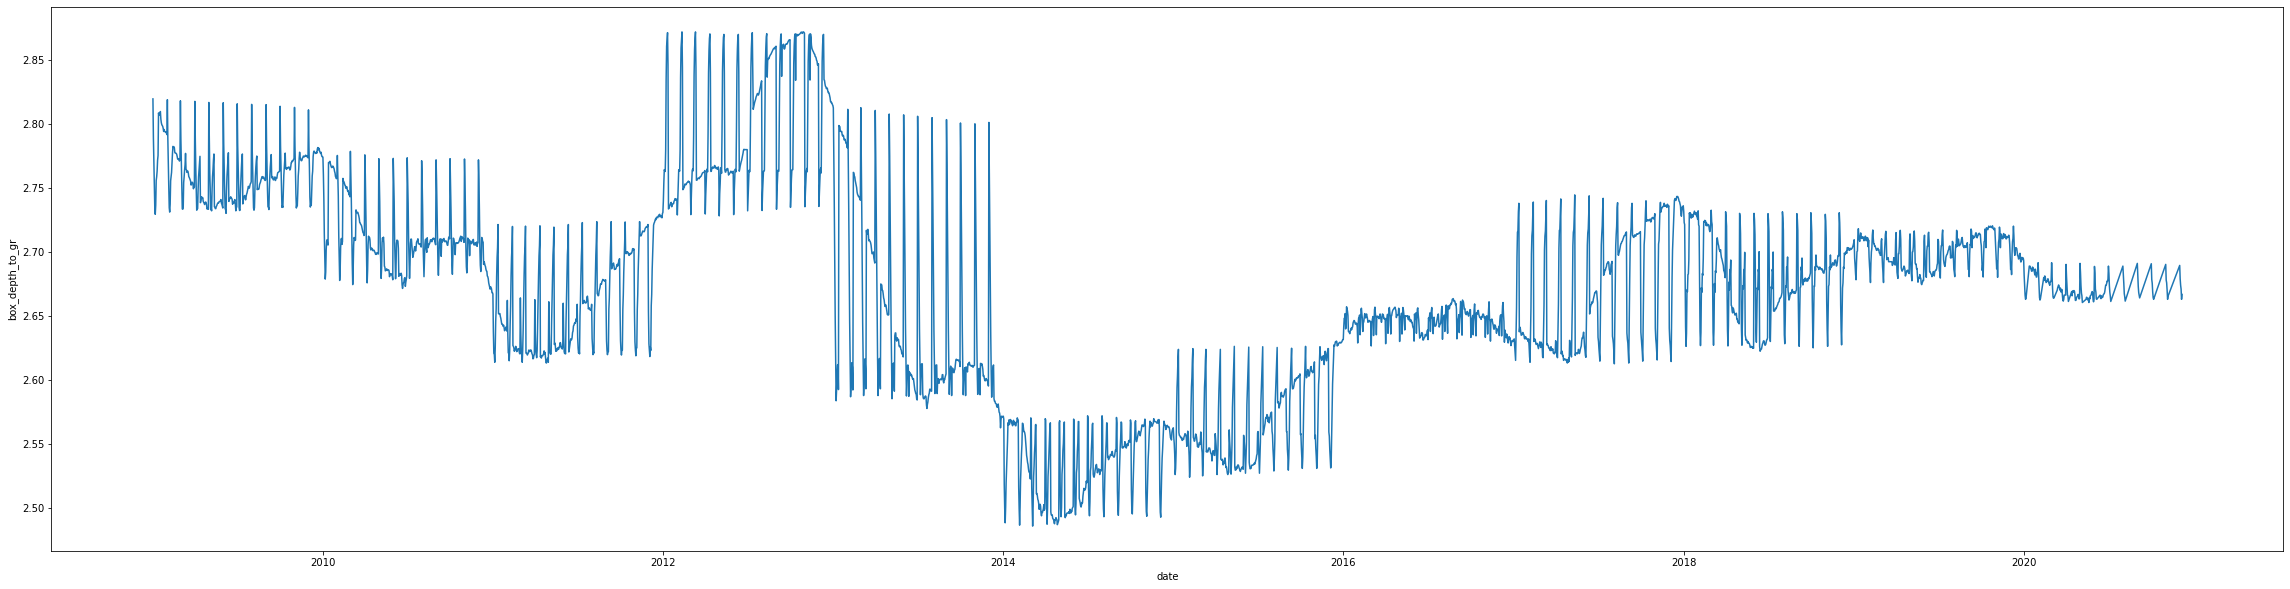

In [53]:
df['box_depth_to_gr'], lmbda = scs.boxcox(df['depth_to_groundwater'] * -1)

plt.figure(figsize=(40,10))
sns.lineplot(x=df['date'], y=df['box_depth_to_gr'])

print('Критерий Дики-Фуллера : ', sm.tsa.stattools.adfuller(df['box_depth_to_gr'])[1])

#### видим что в плане отклонения нулевой гипотезы о нестационарности ряда стало только хуже 